In [1]:
# display, transform, read, split ...
import numpy as np
import matplotlib.pyplot as plt
import splitfolders

# tensorflow
import tensorflow.keras as keras
import tensorflow as tf

# image processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import  Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Dropout is a regularization technique to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.
from tensorflow.keras.layers import Dropout, BatchNormalization
# BatchNormalization normalizes the inputs of each layer to improve training speed and stability.
from tensorflow.keras.regularizers import l2

In [2]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

# define classes name
class_names = ['Anger and aggression','anxiety','happy','sad']

In [4]:
train_generator = train_datagen.flow_from_directory(
    directory="./anamelClassification.v1i.multiclass/train",  # Path to the directory containing the training dataset
    classes=class_names,             # List of class names (subdirectory names) to use for classification
    target_size=(224, 224),          # Resize all images to 224x224 pixels
    batch_size=32,                   # Number of images to return in each batch
    class_mode="categorical",        # The type of classification problem ('categorical' indicates multi-class classification)
)
# test data
test_generator = test_datagen.flow_from_directory( 
    directory="./anamelClassification.v1i.multiclass/test", 
    classes = class_names,
    target_size=(224, 224), 
    batch_size=32, 
    class_mode="categorical", 

)
# validation data
valid_generator = val_datagen.flow_from_directory( 
    directory="./anamelClassification.v1i.multiclass/valid/", 
    classes = class_names,
    target_size=(224, 224), 
    batch_size=32, 
    class_mode="categorical",
     
)

Found 400 images belonging to 4 classes.
Found 50 images belonging to 4 classes.
Found 50 images belonging to 4 classes.


In [5]:
# ResNet50 model
resnet_50 = ResNet50(
    include_top=False,  # Exclude the fully connected (dense) layers on top of the network.
    weights='imagenet', # Load weights pre-trained on the ImageNet dataset.
    input_shape=(224, 224, 3) # Specify the input shape of the images: 224x224 pixels with 3 color channels (RGB).
)
# This means that the weights of these layers will not be updated during training.
for layer in resnet_50.layers:
    layer.trainable = False
    x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = layers.Dense(4, activation='softmax')(x)

# Create the final model
# The inputs are from ResNet50, and the outputs are the predictions
model = Model(inputs=resnet_50.input, outputs=predictions)

In [6]:
def trainModel(model, epochs, optimizer):
    batch_size = 32
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
    
    return model.fit(train_generator,
                     validation_data=valid_generator,
                     epochs=epochs,
                     batch_size=batch_size,
                     callbacks=[early_stopping, reduce_lr])

In [7]:
model_history = trainModel(model = model, epochs = 50, optimizer = "Adam")


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.4707 - loss: 1.5756 - val_accuracy: 0.6600 - val_loss: 0.6806 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.9128 - loss: 0.3181 - val_accuracy: 0.9400 - val_loss: 0.2463 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9329 - loss: 0.1764 - val_accuracy: 0.9000 - val_loss: 0.1916 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.9665 - loss: 0.1109 - val_accuracy: 0.9400 - val_loss: 0.2159 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.9615 - loss: 0.1257 - val_accuracy: 0.9400 - val_loss: 0.1660 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.9730 - loss: 0.0706 - val_accuracy: 0.9200 - val_loss: 0.1973 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9819 - loss: 0.0511 - val_accuracy: 

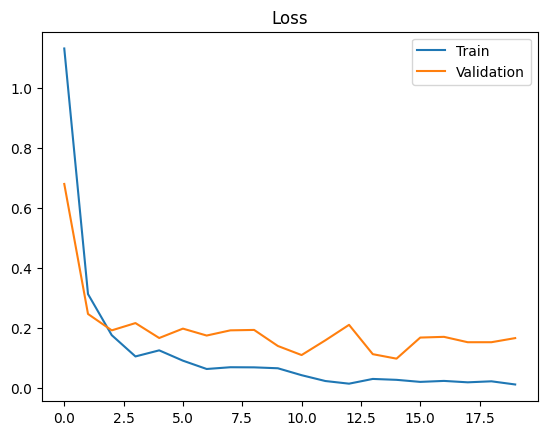

In [8]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

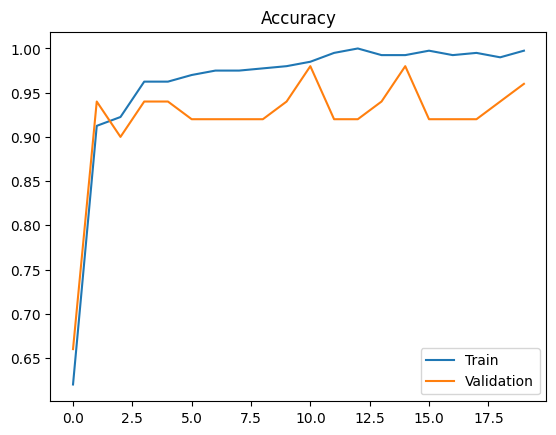

In [9]:
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

In [10]:
test_loss, test_acc = model.evaluate(test_generator)
print("The best accuracy is: ", test_acc*100)
print("The test loss is: ", test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8783 - loss: 0.4666
The best accuracy is:  87.99999952316284
The test loss is:  0.4574434161186218


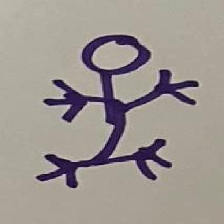

In [ ]:
img = tf.keras.preprocessing.image.load_img('./anamelClassification.v1i.multiclass/test/Anger and aggression/photo_82_2024-04-05_12-16-52_jpg.rf.218c300be1d0544662f84acd899b6908.jpg', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array]) 
img


In [20]:
# generate predictions for samples
predictions = model.predict(img_array)
print(predictions)
# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)
# transform classes number into classes name
class_names[class_id.item()]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
[[9.8274845e-01 1.8779698e-04 1.6574472e-02 4.8934371e-04]]


'Anger and aggression'